In [ ]:
!pip install numpy-stl
!pip install vedo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 5.3 MB/s eta 0:00:00
  Created wheel for vedo: filename=vedo-2024.5.2-py3-none-any.whl size=2807715 sha256=40b32b443592bc82d1ddc09e87dfb1e1324e7d916820e7bb22a84430141b3d84
  Stored in directory: /root/.cache/pip/wheels/27/6c/7a/91b6f4993213d1ee45fc4ab1c623405f9daa0de0e9638c0a13
Successfully built vedo


In [ ]:
import numpy as np
import stl
import vedo as vd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from numba.experimental import jitclass
from numba import njit, int32, float64, float32
from tqdm import tqdm

## 2D Laplace Equation

In [ ]:
def calculate_f(ksi, eta, x_k, y_k, nx_k, ny_k, l_k):

  A_k = l_k ** 2
  B_k = 2 * l_k * (nx_k * (y_k - eta) - ny_k * (x_k - ksi))
  E_k = (x_k - ksi) ** 2 + (y_k - eta) ** 2

  D = np.absolute(4 * A_k * E_k - B_k ** 2)

  if D == 0:
    F1 = l_k / (2 * np.pi) * (np.log(l_k) + (1 + B_k / (2 * A_k)) * np.log(np.absolute(1 + B_k / (2 * A_k))) - B_k / (2 * A_k) * np.log(np.absolute(B_k / (2 * A_k))) - 1)
    F2 = 0
  else:
    F1 = l_k / (4 * np.pi) * (2 * (np.log(l_k) - 1) + (1 + B_k / (2 * A_k)) * np.log(np.absolute(1 + (B_k + E_k) / A_k)) - B_k / (2 * A_k) * np.log(np.absolute(E_k / A_k)) + np.sqrt(D) / A_k * (np.arctan((2 * A_k + B_k) / np.sqrt(D)) - np.arctan(B_k / np.sqrt(D))))
    F2 = l_k * (nx_k * (x_k - ksi) + ny_k * (y_k - eta)) / (np.pi * np.sqrt(D)) * (np.arctan((2 * A_k + B_k) / np.sqrt(D)) - np.arctan(B_k / np.sqrt(D)))

  return F1, F2

calculate_f = np.vectorize(calculate_f)

def linear_system(N, xm, ym, xb, yb, nx, ny, lg, bct, bcv):

  A = np.zeros((N, N))
  B = np.zeros(N)
  phi = np.zeros(N)
  dphi = np.zeros(N)

  for m in tqdm(range(N)):
    for k in range(N):

      F1, F2 = calculate_f(xm[m], ym[m], xb[k], yb[k], nx[k], ny[k], lg[k])

      if k == m:
        delta = 1
      else:
        delta = 0

      if bct[k] == 0:
        A[m, k] = -F1
        B[m] = B[m] + bcv[k] * (0.5 * delta - F2)
      else:
        A[m, k] = F2 - 0.5 * delta
        B[m] = B[m] + bcv[k] * F1

  Z = np.linalg.solve(A, B)

  for i in range(N):
    if bct[i] == 0:
      phi[i] = bcv[i]
      dphi[i] = Z[i]
    else:
      phi[i] = Z[i]
      dphi[i] = bcv[i]

  return phi, dphi


def solution(N, ksi, eta, xb, yb, nx, ny, lg, phi, dphi):
  sum = 0
  for i in range(N):
    F1, F2 = calculate_f(ksi, eta, xb[i], yb[i], nx[i], ny[i], lg[i])
    sum = sum + phi[i] * F2 - dphi[i] * F1

  return sum


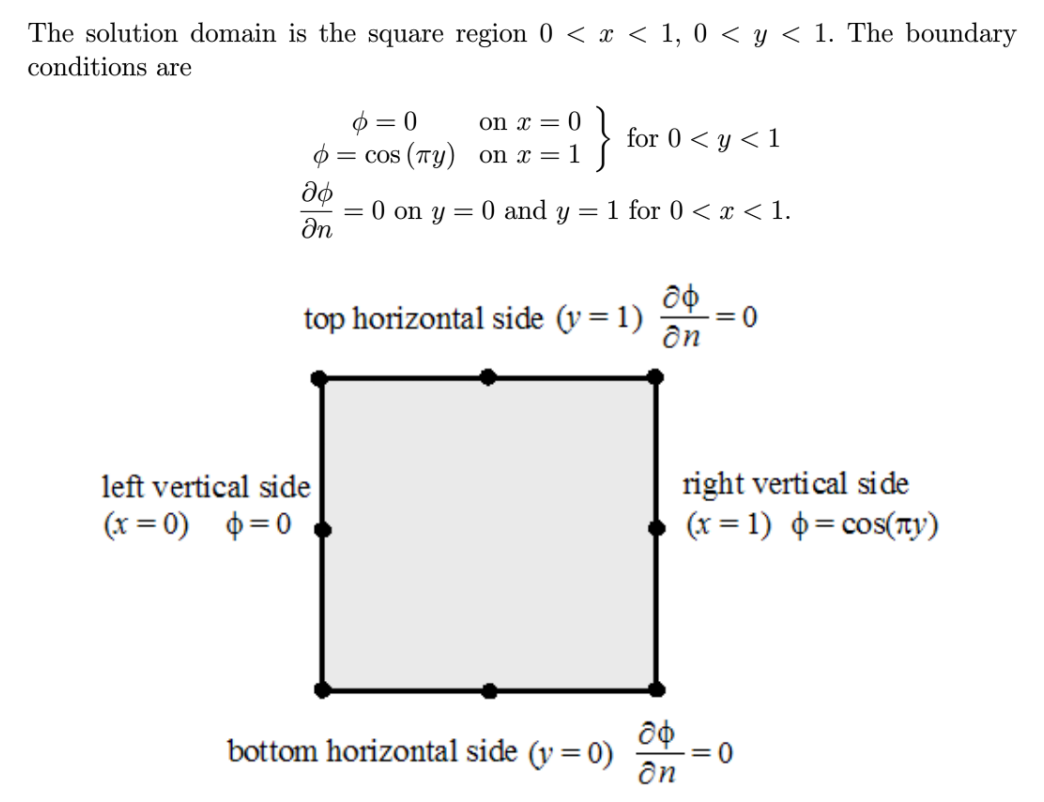

In [ ]:
N0 = 40
N = 4 * N0

dl = 1 / N0
xb = np.zeros(N + 1)
yb = np.zeros(N + 1)

xm = np.zeros(N)
ym = np.zeros(N)
lg = np.zeros(N)
nx = np.zeros(N)
ny = np.zeros(N)
bct = np.zeros(N)
bcv = np.zeros(N)

for i in range(N0):
  xb[i] = i * dl
  yb[i] = 0
  xb[N0 + i] = 1
  yb[N0 + i] = xb[i]
  xb[2 * N0 + i] = 1 - xb[i]
  yb[2 * N0 + i] = 1
  xb[3 * N0 + i] = 0
  yb[3 * N0 + i] = 1 - xb[i]

xb[-1] = xb[0]
yb[-1] = yb[0]

for i in range(N):
  xm[i] = (xb[i] + xb[i + 1]) / 2
  ym[i] = (yb[i] + yb[i + 1]) / 2
  lg[i] = np.sqrt((xb[i + 1] - xb[i]) ** 2 + (yb[i + 1] - yb[i]) ** 2)
  nx[i] = (yb[i + 1] - yb[i]) / lg[i]
  ny[i] = (xb[i] - xb[i + 1]) / lg[i]


for i in range(N):
  if i <= N0:
    bct[i] = 1
    bcv[i] = 0
  elif ((i > N0) and (i <= 2 * N0)):
    bct[i] = 0
    bcv[i] = np.cos(np.pi * ym[i])
  elif ((i > 2 * N0) and (i <= 3 * N0)):
    bct[i] = 1
    bcv[i] = 0
  else:
    bct[i] = 0
    bcv[i] = 0

In [ ]:
phi, dphi = linear_system(N, xm, ym, xb, yb, nx, ny, lg, bct, bcv)

x, y = np.linspace(0.1, 0.9, 20), np.linspace(0.1, 0.9, 20)
X, Y = np.meshgrid(x, y)
sol = solution(N, X, Y, xb, yb, nx, ny, lg, phi, dphi)

100%|██████████| 160/160 [00:03<00:00, 53.18it/s]


In [ ]:
ksi = 0.9
eta = 0.4
print(f'BEM solution: {solution(N, ksi, eta, xb, yb, nx, ny, lg, phi, dphi)}; Exact solution: {np.sinh(np.pi * ksi) * np.cos(np.pi * eta) / np.sinh(np.pi)} at point (0.9, 0.4)')
mean_error = np.mean(np.absolute(sol - np.sinh(np.pi * X) * np.cos(np.pi * Y) / np.sinh(np.pi)))
print(f"Mean error : {mean_error}")

BEM solution: 0.2244851758577654; Exact solution: 0.22533757616022249 at point (0.9, 0.4)
Mean error : 0.001423849184966671


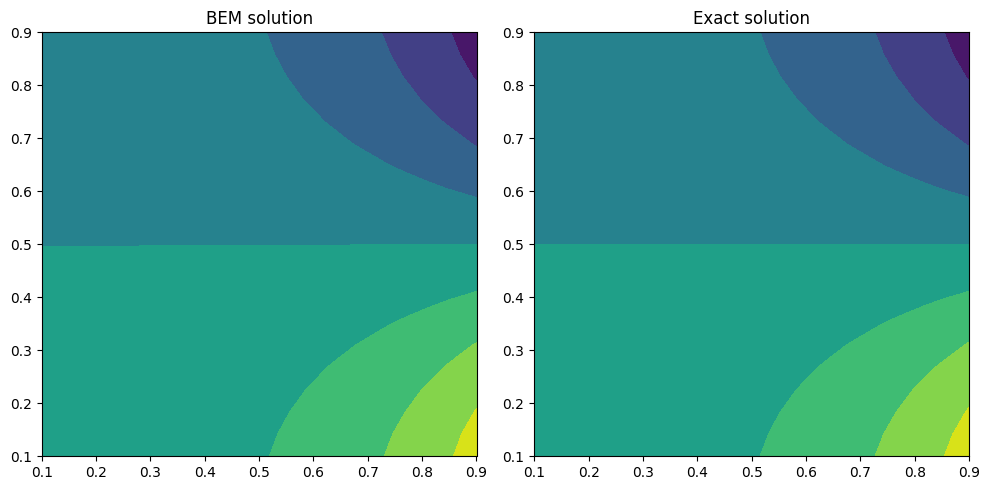

In [ ]:
fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
ax[0].contourf(X, Y, sol)
ax[0].set_title('BEM solution')
ax[1].contourf(X, Y, np.sinh(np.pi * X) * np.cos(np.pi * Y) / np.sinh(np.pi))
ax[1].set_title('Exact solution')
plt.tight_layout()

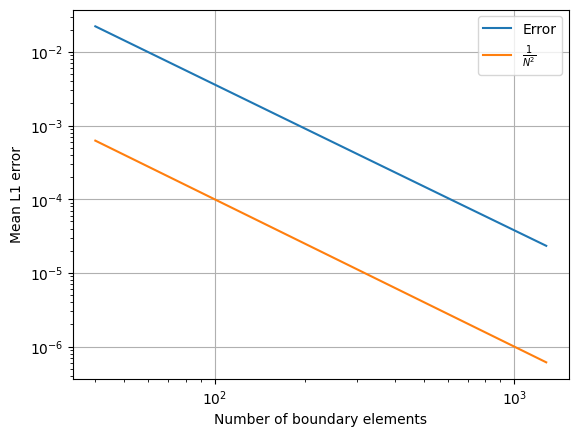

In [ ]:
N = np.array([40, 160, 320, 640, 1280])
error = np.array([0.022286952307251466, 0.001423849184966671, 0.00036065350491198565, 9.15476374719151e-05, 2.330940378103632e-05])
plt.plot(N, error, label='Error')
plt.plot(N, 1 / N ** 2, label=r'$\frac{1}{N^2}$')
plt.yscale('log')
plt.ylabel('Mean L1 error')
plt.xlabel('Number of boundary elements')
plt.xscale('log')
plt.legend()
plt.grid()

## 3D Laplace equation

In [ ]:

def BE3D(N, xt, yt, zt):

  x21 = xt[:, 1] - xt[:, 0]
  x31 = xt[:, 2] - xt[:, 0]
  x23 = xt[:, 1] - xt[:, 2]
  y21 = yt[:, 1] - yt[:, 0]
  y31 = yt[:, 2] - yt[:, 0]
  y23 = yt[:, 1] - yt[:, 2]
  z21 = zt[:, 1] - zt[:, 0]
  z31 = zt[:, 2] - zt[:, 0]
  z23 = zt[:, 1] - zt[:, 2]

  n_x = y21 * z31 - z21 * y31
  n_y = z21 * x31 - x21 * z31
  n_z = x21 * y31 - y21 * x31
  n_norm = np.sqrt(n_x ** 2 + n_y ** 2 + n_z ** 2)
  n_x = n_x / n_norm
  n_y = n_y / n_norm
  n_z = n_z / n_norm

  alpha = np.sqrt(x21 ** 2 + y21 ** 2 + z21 ** 2)
  beta = np.sqrt(x23 ** 2 + y23 ** 2 + z23 ** 2)
  gamma = np.sqrt(x31 ** 2 + y31 ** 2 + z31 ** 2)
  sigma = (alpha + beta + gamma) / 2
  jac = 2 * np.sqrt(sigma * (sigma - alpha) * (sigma - beta) * (sigma - gamma))

  pc = np.zeros((N, 3, 3))
  xm = np.zeros(N)
  ym = np.zeros(N)
  zm = np.zeros(N)

  for i in range(N):

    if np.absolute(n_z[i]) >= 1 / np.sqrt(3):
      pc[i, 0, 0] = x21[i]
      pc[i, 0, 1] = x31[i]
      pc[i, 0, 2] = xt[i, 0]
      pc[i, 1, 0] = y21[i]
      pc[i, 1, 1] = y31[i]
      pc[i, 1, 2] = yt[i, 0]
      pc[i, 2, 0] = - (n_x[i] * pc[i, 0, 0] + n_y[i] * pc[i, 1, 0]) / n_z[i]
      pc[i, 2, 1] = - (n_x[i] * pc[i, 0, 1] + n_y[i] * pc[i, 1, 1]) / n_z[i]
      pc[i, 2, 2] = zt[i, 0]

    elif np.absolute(n_y[i]) >= 1 / np.sqrt(3):
      pc[i, 0, 0] = x21[i]
      pc[i, 0, 1] = x31[i]
      pc[i, 0, 2] = xt[i, 0]
      pc[i, 2, 0] = z21[i]
      pc[i, 2, 1] = z31[i]
      pc[i, 2, 2] = zt[i, 0]
      pc[i, 1, 0] = - (n_x[i] * pc[i, 0, 0] + n_z[i] * pc[i, 2, 0]) / n_y[i]
      pc[i, 1, 1] = - (n_x[i] * pc[i, 0, 1] + n_z[i] * pc[i, 2, 1]) / n_y[i]
      pc[i, 1, 2] = yt[i, 0]

    else:
      pc[i, 1, 0] = y21[i]
      pc[i, 1, 1] = y31[i]
      pc[i, 1, 2] = yt[i, 0]
      pc[i, 2, 0] = z21[i]
      pc[i, 2, 1] = z31[i]
      pc[i, 2, 2] = zt[i, 0]
      pc[i, 0, 0] = - (n_z[i] * pc[i, 2, 0] + n_y[i] * pc[i, 1, 0]) / n_x[i]
      pc[i, 0, 1] = - (n_z[i] * pc[i, 2, 1] + n_y[i] * pc[i, 1, 1]) / n_x[i]
      pc[i, 0, 2] = xt[i, 0]

    xm[i] = pc[i, 0, 0] / 4 + pc[i, 0, 1] / 2 + pc[i, 0, 2]
    ym[i] = pc[i, 1, 0] / 4 + pc[i, 1, 1] / 2 + pc[i, 1, 2]
    zm[i] = pc[i, 2, 0] / 4 + pc[i, 2, 1] / 2 + pc[i, 2, 2]

  t_gauss = np.zeros(16)
  v_gauss = np.zeros(16)

  t_gauss[0] = 0.25 * (1 + 1 / np.sqrt(3))
  v_gauss[0] = t_gauss[0]
  t_gauss[1] = t_gauss[0]
  v_gauss[1] = 0.25 * (1 - 1 / np.sqrt(3))
  t_gauss[2] = v_gauss[1]
  v_gauss[2] = t_gauss[0]
  t_gauss[3] = v_gauss[1]
  v_gauss[3] = v_gauss[1]
  t_gauss[4] = 0.25 * (3 + 1 / np.sqrt(3))
  v_gauss[4] = t_gauss[0]
  t_gauss[5] = t_gauss[4]
  v_gauss[5] = v_gauss[1]
  t_gauss[6] = 0.25 * (3 - 1 / np.sqrt(3))
  v_gauss[6] = t_gauss[0]
  t_gauss[7] = t_gauss[6]
  v_gauss[7] = v_gauss[1]
  t_gauss[8] = t_gauss[4]
  v_gauss[8] = t_gauss[4]
  t_gauss[9] = t_gauss[4]
  v_gauss[9] = t_gauss[6]
  t_gauss[10] = t_gauss[6]
  v_gauss[10] = t_gauss[4]
  t_gauss[11] = t_gauss[6]
  v_gauss[11] = t_gauss[6]
  t_gauss[12] = t_gauss[0]
  v_gauss[12] = t_gauss[4]
  t_gauss[13] = t_gauss[0]
  v_gauss[13] = t_gauss[6]
  t_gauss[14] = v_gauss[1]
  v_gauss[14] = t_gauss[4]
  t_gauss[15] = v_gauss[1]
  v_gauss[15] = t_gauss[6]

  return n_x, n_y, n_z, xm, ym, zm, jac, pc, t_gauss, v_gauss


def FundSol3D(x, y, z, ksi, eta, zeta):

  return -1 / (4 * np.pi) * 1 / np.sqrt((x - ksi) ** 2 + (y - eta) ** 2 + (z - zeta) ** 2)


def DFundSol3D(x, y, z, ksi, eta, zeta, n_x, n_y, n_z):

  return ((x - ksi) * n_x + (y - eta) * n_y + (z - zeta) * n_z) / (4 * np.pi * (np.sqrt((x - ksi) ** 2 + (y - eta) ** 2 + (z - zeta) ** 2)) ** 3)


def Calculate_D(ksi, eta, zeta, k, nx, ny, nz, jac, pc, t_gauss, v_gauss):

  D1 = 0
  D2 = 0

  for i in range(16):
    u_t = t_gauss[i] * (1 - v_gauss[i])
    x_k = pc[k, 0, 0] * u_t + pc[k, 0, 1] * v_gauss[i] + pc[k, 0, 2]
    y_k = pc[k, 1, 0] * u_t + pc[k, 1, 1] * v_gauss[i] + pc[k, 1, 2]
    z_k = pc[k, 2, 0] * u_t + pc[k, 2, 1] * v_gauss[i] + pc[k, 2, 2]
    D1 += FundSol3D(x_k, y_k, z_k, ksi, eta, zeta) * (1 - v_gauss[i])
    D2 += DFundSol3D(x_k, y_k, z_k, ksi, eta, zeta, nx, ny, nz) * (1 - v_gauss[i])

  D1 = jac[k] * D1 / 16
  D2 = jac[k] * D2 / 16

  return D1, D2


def linear_system(N, xm, ym, zm, nx, ny, nz, bct, bcv, jac, pc, t_gauss, v_gauss):

  A = np.zeros((N, N))
  B = np.zeros(N)
  phi = np.zeros(N)
  dphi = np.zeros(N)

  for m in tqdm(range(N)):
    for k in range(N):

      D1, D2 = Calculate_D(xm[m], ym[m], zm[m], k, nx[k], ny[k], nz[k], jac, pc, t_gauss, v_gauss)

      if k == m:
        delta = 1
      else:
        delta = 0

      if bct[k] == 0:
        A[m, k] = -D1
        B[m] = B[m] + bcv[k] * (0.5 * delta - D2)
      else:
        A[m, k] = D2 - 0.5 * delta
        B[m] = B[m] + bcv[k] * D1

  Z = np.linalg.solve(A, B)

  for i in range(N):
    if bct[i] == 0:
      phi[i] = bcv[i]
      dphi[i] = Z[i]
    else:
      phi[i] = Z[i]
      dphi[i] = bcv[i]

  return phi, dphi


def solution(N, ksi, eta, zeta, nx, ny, nz, phi, dphi, jac, pc, t_gauss, v_gauss):
  sum = 0
  for i in range(N):
    D1, D2 = Calculate_D(ksi, eta, zeta, i, nx[i], ny[i], nz[i], jac, pc, t_gauss, v_gauss)
    sum = sum + phi[i] * D2 - dphi[i] * D1

  return sum


In [ ]:
N0 = 4
N = 12 * N0 ** 2
dl = 1 / (2 * N0)
ie = -2

xt = np.zeros((N, 3))
yt = np.zeros((N, 3))
zt = np.zeros((N, 3))

for i in range(N0):
  for j in range(N0):

    ie += 2
    s1 = (2 * i + 1) * dl
    s2 = (2 * j + 1) * dl

    xt[ie, 0] = 0
    yt[ie, 0] = s1 - dl
    zt[ie, 0] = s2 - dl
    xt[ie, 1] = 0
    yt[ie, 1] = s1 + dl
    zt[ie, 1] = s2 + dl
    xt[ie, 2] = 0
    yt[ie, 2] = s1 + dl
    zt[ie, 2] = s2 - dl

    xt[ie + 1, 0] = 0
    yt[ie + 1, 0] = s1 - dl
    zt[ie + 1, 0] = s2 - dl
    xt[ie + 1, 1] = 0
    yt[ie + 1, 1] = s1 - dl
    zt[ie + 1, 1] = s2 + dl
    xt[ie + 1, 2] = 0
    yt[ie + 1, 2] = s1 + dl
    zt[ie + 1, 2] = s2 + dl


    xt[2 * N0 ** 2 + ie, 0] = 1
    yt[2 * N0 ** 2 + ie, 0] = s1 - dl
    zt[2 * N0 ** 2 + ie, 0] = s2 - dl
    xt[2 * N0 ** 2 + ie, 1] = 1
    yt[2 * N0 ** 2 + ie, 1] = s1 + dl
    zt[2 * N0 ** 2 + ie, 1] = s2 - dl
    xt[2 * N0 ** 2 + ie, 2] = 1
    yt[2 * N0 ** 2 + ie, 2] = s1 + dl
    zt[2 * N0 ** 2 + ie, 2] = s2 + dl

    xt[2 * N0 ** 2 + ie + 1, 0] = 1
    yt[2 * N0 ** 2 + ie + 1, 0] = s1 - dl
    zt[2 * N0 ** 2 + ie + 1, 0] = s2 - dl
    xt[2 * N0 ** 2 + ie + 1, 1] = 1
    yt[2 * N0 ** 2 + ie + 1, 1] = s1 + dl
    zt[2 * N0 ** 2 + ie + 1, 1] = s2 + dl
    xt[2 * N0 ** 2 + ie + 1, 2] = 1
    yt[2 * N0 ** 2 + ie + 1, 2] = s1 - dl
    zt[2 * N0 ** 2 + ie + 1, 2] = s2 + dl


    xt[4 * N0 ** 2 + ie, 0] = s1 + dl
    yt[4 * N0 ** 2 + ie, 0] = 0
    zt[4 * N0 ** 2 + ie, 0] = s2 - dl
    xt[4 * N0 ** 2 + ie, 1] = s1 - dl
    yt[4 * N0 ** 2 + ie, 1] = 0
    zt[4 * N0 ** 2 + ie, 1] = s2 + dl
    xt[4 * N0 ** 2 + ie, 2] = s1 - dl
    yt[4 * N0 ** 2 + ie, 2] = 0
    zt[4 * N0 ** 2 + ie, 2] = s2 - dl

    xt[4 * N0 ** 2 + ie + 1, 0] = s1 + dl
    yt[4 * N0 ** 2 + ie + 1, 0] = 0
    zt[4 * N0 ** 2 + ie + 1, 0] = s2 - dl
    xt[4 * N0 ** 2 + ie + 1, 1] = s1 + dl
    yt[4 * N0 ** 2 + ie + 1, 1] = 0
    zt[4 * N0 ** 2 + ie + 1, 1] = s2 + dl
    xt[4 * N0 ** 2 + ie + 1, 2] = s1 - dl
    yt[4 * N0 ** 2 + ie + 1, 2] = 0
    zt[4 * N0 ** 2 + ie + 1, 2] = s2 + dl


    xt[6 * N0 ** 2 + ie, 0] = s1 - dl
    yt[6 * N0 ** 2 + ie, 0] = 1
    zt[6 * N0 ** 2 + ie, 0] = s2 - dl
    xt[6 * N0 ** 2 + ie, 1] = s1 - dl
    yt[6 * N0 ** 2 + ie, 1] = 1
    zt[6 * N0 ** 2 + ie, 1] = s2 + dl
    xt[6 * N0 ** 2 + ie, 2] = s1 + dl
    yt[6 * N0 ** 2 + ie, 2] = 1
    zt[6 * N0 ** 2 + ie, 2] = s2 - dl

    xt[6 * N0 ** 2 + ie + 1, 0] = s1 - dl
    yt[6 * N0 ** 2 + ie + 1, 0] = 1
    zt[6 * N0 ** 2 + ie + 1, 0] = s2 + dl
    xt[6 * N0 ** 2 + ie + 1, 1] = s1 + dl
    yt[6 * N0 ** 2 + ie + 1, 1] = 1
    zt[6 * N0 ** 2 + ie + 1, 1] = s2 + dl
    xt[6 * N0 ** 2 + ie + 1, 2] = s1 + dl
    yt[6 * N0 ** 2 + ie + 1, 2] = 1
    zt[6 * N0 ** 2 + ie + 1, 2] = s2 - dl


    xt[8 * N0 ** 2 + ie, 0] = s1 - dl
    yt[8 * N0 ** 2 + ie, 0] = s2 - dl
    zt[8 * N0 ** 2 + ie, 0] = 0
    xt[8 * N0 ** 2 + ie, 1] = s1 + dl
    yt[8 * N0 ** 2 + ie, 1] = s2 + dl
    zt[8 * N0 ** 2 + ie, 1] = 0
    xt[8 * N0 ** 2 + ie, 2] = s1 + dl
    yt[8 * N0 ** 2 + ie, 2] = s2 - dl
    zt[8 * N0 ** 2 + ie, 2] = 0

    xt[8 * N0 ** 2 + ie + 1, 0] = s1 - dl
    yt[8 * N0 ** 2 + ie + 1, 0] = s2 - dl
    zt[8 * N0 ** 2 + ie + 1, 0] = 0
    xt[8 * N0 ** 2 + ie + 1, 1] = s1 - dl
    yt[8 * N0 ** 2 + ie + 1, 1] = s2 + dl
    zt[8 * N0 ** 2 + ie + 1, 1] = 0
    xt[8 * N0 ** 2 + ie + 1, 2] = s1 + dl
    yt[8 * N0 ** 2 + ie + 1, 2] = s2 + dl
    zt[8 * N0 ** 2 + ie + 1, 2] = 0


    xt[10 * N0 ** 2 + ie, 0] = s1 - dl
    yt[10 * N0 ** 2 + ie, 0] = s2 - dl
    zt[10 * N0 ** 2 + ie, 0] = 1
    xt[10 * N0 ** 2 + ie, 1] = s1 + dl
    yt[10 * N0 ** 2 + ie, 1] = s2 - dl
    zt[10 * N0 ** 2 + ie, 1] = 1
    xt[10 * N0 ** 2 + ie, 2] = s1 + dl
    yt[10 * N0 ** 2 + ie, 2] = s2 + dl
    zt[10 * N0 ** 2 + ie, 2] = 1

    xt[10 * N0 ** 2 + ie + 1, 0] = s1 - dl
    yt[10 * N0 ** 2 + ie + 1, 0] = s2 - dl
    zt[10 * N0 ** 2 + ie + 1, 0] = 1
    xt[10 * N0 ** 2 + ie + 1, 1] = s1 + dl
    yt[10 * N0 ** 2 + ie + 1, 1] = s2 + dl
    zt[10 * N0 ** 2 + ie + 1, 1] = 1
    xt[10 * N0 ** 2 + ie + 1, 2] = s1 - dl
    yt[10 * N0 ** 2 + ie + 1, 2] = s2 + dl
    zt[10 * N0 ** 2 + ie + 1, 2] = 1

n_x, n_y, n_z, xm, ym, zm, jac, pc, t_gauss, v_gauss = BE3D(N, xt, yt, zt)
bct = np.zeros(N)
bcv = np.zeros(N)

for i in range(N):
  if (i <= 2 * N0 ** 2):
    bct[i] = 0
    bcv[i] = FundSol3D(xm[i], ym[i], zm[i], 0, 0, 1.5)
  else:
    bct[i] = 1
    bcv[i] = DFundSol3D(xm[i], ym[i], zm[i], 0, 0, 1.5, n_x[i], n_y[i], n_z[i])

phi, dphi = linear_system(N, xm, ym, zm, n_x, n_y, n_z, bct, bcv, jac, pc, t_gauss, v_gauss)

100%|██████████| 192/192 [00:07<00:00, 24.57it/s]


In [ ]:
ksi = 0.1
eta = 0.1
zeta = 0.9

print(f'BEM solution at point ({ksi}, {eta}, {zeta}): {solution(N, ksi, eta, zeta, n_x, n_y, n_z, phi, dphi, jac, pc, t_gauss, v_gauss)}')
print(f'Exact solution at point ({ksi}, {eta}, {zeta}): {FundSol3D(ksi, eta, zeta, 0, 0, 1.5)}')

BEM solution at point (0.1, 0.1, 0.9): -0.12739397122100743
Exact solution at point (0.1, 0.1, 0.9): -0.1290917052417645


In [ ]:
x = np.linspace(0.1, 0.9, 8)
y = np.linspace(0.1, 0.9, 8)
z = np.linspace(0.1, 0.9, 8)

X, Y, Z = np.meshgrid(x, y, z)

bem_sol = solution(N, X, Y, Z, n_x, n_y, n_z, phi, dphi, jac, pc, t_gauss, v_gauss)
exact_sol = FundSol3D(X, Y, Z, 0, 0, 1.5)

mean_error = np.mean(np.absolute(bem_sol - exact_sol))
print(mean_error)

0.00042065556358646816


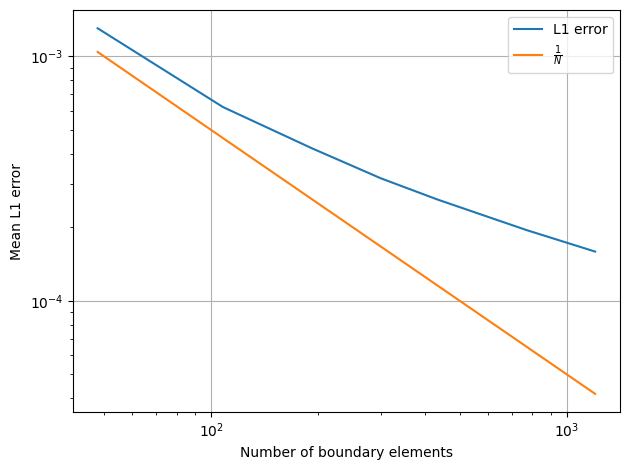

In [ ]:
error = np.array([0.0013020634681492256, 0.0006201301204313597, 0.00042065556358646816, 0.00031700367308515836, 0.00025987830940237737, 0.0001949589201884373, 0.0001590366201391356])
N = np.array([48, 108, 192, 300, 432, 768, 1200])

plt.plot(N, error, label='L1 error')
plt.plot(N, 0.05 / N, label=r'$\frac{1}{N}$')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of boundary elements')
plt.ylabel('Mean L1 error')
plt.tight_layout()

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b):
  return a * x ** b

params = curve_fit(func, N, error)
print(params)

(array([ 0.02458574, -0.76460507]), array([[ 2.06996550e-05, -1.91135213e-04],
       [-1.91135213e-04,  1.80871033e-03]]))


## Class for 3D Laplace BEM

In [ ]:
def func(deg):
  x, w = np.polynomial.legendre.leggauss(deg)

  gauss_pts = np.array(np.meshgrid(x, x, indexing='ij')).reshape(2, -1).T
  t_gauss = (gauss_pts[:, 0] + 1) / 2
  v_gauss = (gauss_pts[:, 1] + 1) / 2
  weights = (w * w[:,None]).ravel() / 4
  return t_gauss, v_gauss, weights

func(4)

(array([0.06943184, 0.06943184, 0.06943184, 0.06943184, 0.33000948,
        0.33000948, 0.33000948, 0.33000948, 0.66999052, 0.66999052,
        0.66999052, 0.66999052, 0.93056816, 0.93056816, 0.93056816,
        0.93056816]),
 array([0.06943184, 0.33000948, 0.66999052, 0.93056816, 0.06943184,
        0.33000948, 0.66999052, 0.93056816, 0.06943184, 0.33000948,
        0.66999052, 0.93056816, 0.06943184, 0.33000948, 0.66999052,
        0.93056816]),
 array([0.03025075, 0.05671296, 0.05671296, 0.03025075, 0.05671296,
        0.10632333, 0.10632333, 0.05671296, 0.05671296, 0.10632333,
        0.10632333, 0.05671296, 0.03025075, 0.05671296, 0.05671296,
        0.03025075]))

In [ ]:
@njit
def fund_sol3d(x, y, z, ksi, eta, zeta):
    """
    Function that calculates fundamental solution of Laplace 3D equation.
    :param x: float
    The x - coordinate of the point at which the fundamental solution is calculated.
    :param y: float
    The y - coordinate of the point at which the fundamental solution is calculated.
    :param z: float
    The z - coordinate of the point at which the fundamental solution is calculated.
    :param ksi: float
    Singular point x - coordinate of fundamental solution.
    :param eta: float
    Singular point y - coordinate of fundamental solution.
    :param zeta: float
    Singular point z - coordinate of fundamental solution.
    :return: float
    Value of the fundamental solution at point (x, y, z).
    """
    return -1 / (4 * np.pi) * 1 / np.sqrt((x - ksi) ** 2 + (y - eta) ** 2 + (z - zeta) ** 2)


@njit
def gauss_quad_points(n_points, n_blocks):
  t_gauss = np.zeros(n_points * n_blocks, dtype=np.float64)
  v_gauss = np.zeros(n_points * n_blocks, dtype=np.float64)

  if n_points == 4:
    sample_t = 1 / np.sqrt(3) * np.array([1, 1, -1, -1])
    sample_v = 1 / np.sqrt(3) * np.array([1, -1, 1, -1])

  elif n_points == 16:
    sample_t = np.array([-0.86113631, -0.86113631, -0.86113631, -0.86113631, -0.33998104,
                         -0.33998104, -0.33998104, -0.33998104,  0.33998104,  0.33998104,
                          0.33998104,  0.33998104,  0.86113631,  0.86113631,  0.86113631,
                          0.86113631])
    sample_v = np.array([-0.86113631, -0.33998104,  0.33998104,  0.86113631, -0.86113631,
                         -0.33998104,  0.33998104,  0.86113631, -0.86113631, -0.33998104,
                          0.33998104,  0.86113631, -0.86113631, -0.33998104,  0.33998104,
                          0.86113631])


  size = int(np.sqrt(n_blocks))
  block = np.arange(0, n_blocks).reshape(size, size)

  for v_block in range(size):
    for t_block in range(size):
      block_id = n_points * block[v_block, t_block]
      t_gauss[block_id:block_id + n_points] = (sample_t + 1 + 2 * t_block) / 4
      v_gauss[block_id:block_id + n_points] = (sample_v + 1 + 2 * v_block) / 4

  return t_gauss, v_gauss


def stl2points(path):
    """
    Function for reading a stl file and obtaining the coordinates of the vertices of the boundary elements.
    :param path: string
    The path to the stl file.
    :return: tuple of int - N and array_like xt, yt, zt (N, 3), where N - number of boundary elements.
    Number of triangles and its vertices coordinates.
    """
    scaffold = stl.mesh.Mesh.from_file(path)
    vertices = scaffold.vectors
    N = vertices.shape[0]
    xt = np.array(vertices[:, :, 0], dtype=np.float64)
    yt = np.array(vertices[:, :, 1], dtype=np.float64)
    zt = np.array(vertices[:, :, 2], dtype=np.float64)
    return N, xt, yt, zt

@njit
def dfund_sol3d(x, y, z, ksi, eta, zeta, n_x, n_y, n_z):
    """
    Function that calculates derivative of fundamental solution along normal vector of Laplace 3D equation.
    :param x: float
    The x - coordinate of the point at which the fundamental solution is calculated.
    :param y: float
    The y - coordinate of the point at which the fundamental solution is calculated.
    :param z: float
    The z - coordinate of the point at which the fundamental solution is calculated.
    :param ksi: float
    Singular point x - coordinate of fundamental solution.
    :param eta: float
    Singular point y - coordinate of fundamental solution.
    :param zeta: float
    Singular point z - coordinate of fundamental solution.
    :param n_x: float
    The x - component of normal vector to boundary element.
    :param n_y: float
    The y - component of normal vector to boundary element.
    :param n_z: float
    The z - component of normal vector to boundary element.
    :return: float
    Value of the derivative of fundamental solution along normal vector (n_x, n_y, n_z) at point (x, y, z).
    """
    return ((x - ksi) * n_x + (y - eta) * n_y + (z - zeta) * n_z) / (4 * np.pi * (np.sqrt((x - ksi) ** 2 + (y - eta) ** 2 + (z - zeta) ** 2)) ** 3)

spec = [('N', int32), ('xt', float64[:, :]), ('yt', float64[:, :]), ('zt', float64[:, :]),
        ('n_x', float64[:]), ('n_y', float64[:]), ('n_z', float64[:]), ('jac', float64[:]),
        ('pc', float64[:, :, :]), ('xm', float64[:]), ('ym', float64[:]), ('zm', float64[:]),
        ('t_gauss', float64[:]), ('v_gauss', float64[:])]

@jitclass(spec)
class BEMLaplace3D:

    def __init__(self, N, xt, yt, zt):
        """
        Instance initialization of Boundary Element Method solver for 3D Laplace equation.
        Calculation of auxiliary elements: coordinates of the normal vector to the boundary element,
        setting points for Gaussian quadrature, area of the boundary element and its parameterization.
        :param N: int
        Number of boundary elements.
        :param xt: array_like (N, 3)
        The x - coordinates of triangle boundary element vertices.
        :param yt: array_like (N, 3)
        The y - coordinates of triangle boundary element vertices.
        :param zt: array_like (N, 3)
        The z - coordinates of triangle boundary element vertices.
        """
        self.N = N
        self.xt = xt
        self.yt = yt
        self.zt = zt

        x21 = xt[:, 1] - xt[:, 0]
        x31 = xt[:, 2] - xt[:, 0]
        x23 = xt[:, 1] - xt[:, 2]
        y21 = yt[:, 1] - yt[:, 0]
        y31 = yt[:, 2] - yt[:, 0]
        y23 = yt[:, 1] - yt[:, 2]
        z21 = zt[:, 1] - zt[:, 0]
        z31 = zt[:, 2] - zt[:, 0]
        z23 = zt[:, 1] - zt[:, 2]

        n_x = y21 * z31 - z21 * y31
        n_y = z21 * x31 - x21 * z31
        n_z = x21 * y31 - y21 * x31
        n_norm = np.sqrt(n_x ** 2 + n_y ** 2 + n_z ** 2)
        n_x = n_x / n_norm
        n_y = n_y / n_norm
        n_z = n_z / n_norm

        self.n_x = n_x
        self.n_y = n_y
        self.n_z = n_z

        alpha = np.sqrt(x21 ** 2 + y21 ** 2 + z21 ** 2)
        beta = np.sqrt(x23 ** 2 + y23 ** 2 + z23 ** 2)
        gamma = np.sqrt(x31 ** 2 + y31 ** 2 + z31 ** 2)
        sigma = (alpha + beta + gamma) / 2
        jac = 2 * np.sqrt(sigma * (sigma - alpha) * (sigma - beta) * (sigma - gamma))

        self.jac = jac

        pc = np.zeros((N, 3, 3), dtype=np.float64)
        xm = np.zeros(N, dtype=np.float64)
        ym = np.zeros(N, dtype=np.float64)
        zm = np.zeros(N, dtype=np.float64)

        for i in range(N):

            if np.absolute(n_z[i]) >= 1 / np.sqrt(3):
                pc[i, 0, 0] = x21[i]
                pc[i, 0, 1] = x31[i]
                pc[i, 0, 2] = xt[i, 0]
                pc[i, 1, 0] = y21[i]
                pc[i, 1, 1] = y31[i]
                pc[i, 1, 2] = yt[i, 0]
                pc[i, 2, 0] = - (n_x[i] * pc[i, 0, 0] + n_y[i] * pc[i, 1, 0]) / n_z[i]
                pc[i, 2, 1] = - (n_x[i] * pc[i, 0, 1] + n_y[i] * pc[i, 1, 1]) / n_z[i]
                pc[i, 2, 2] = zt[i, 0]

            elif np.absolute(n_y[i]) >= 1 / np.sqrt(3):
                pc[i, 0, 0] = x21[i]
                pc[i, 0, 1] = x31[i]
                pc[i, 0, 2] = xt[i, 0]
                pc[i, 2, 0] = z21[i]
                pc[i, 2, 1] = z31[i]
                pc[i, 2, 2] = zt[i, 0]
                pc[i, 1, 0] = - (n_x[i] * pc[i, 0, 0] + n_z[i] * pc[i, 2, 0]) / n_y[i]
                pc[i, 1, 1] = - (n_x[i] * pc[i, 0, 1] + n_z[i] * pc[i, 2, 1]) / n_y[i]
                pc[i, 1, 2] = yt[i, 0]

            else:
                pc[i, 1, 0] = y21[i]
                pc[i, 1, 1] = y31[i]
                pc[i, 1, 2] = yt[i, 0]
                pc[i, 2, 0] = z21[i]
                pc[i, 2, 1] = z31[i]
                pc[i, 2, 2] = zt[i, 0]
                pc[i, 0, 0] = - (n_z[i] * pc[i, 2, 0] + n_y[i] * pc[i, 1, 0]) / n_x[i]
                pc[i, 0, 1] = - (n_z[i] * pc[i, 2, 1] + n_y[i] * pc[i, 1, 1]) / n_x[i]
                pc[i, 0, 2] = xt[i, 0]

            xm[i] = pc[i, 0, 0] / 4 + pc[i, 0, 1] / 2 + pc[i, 0, 2]
            ym[i] = pc[i, 1, 0] / 4 + pc[i, 1, 1] / 2 + pc[i, 1, 2]
            zm[i] = pc[i, 2, 0] / 4 + pc[i, 2, 1] / 2 + pc[i, 2, 2]

        self.pc = pc
        self.xm = xm
        self.ym = ym
        self.zm = zm

        t_gauss, v_gauss = gauss_quad_points(4, 4)

        self.t_gauss = t_gauss
        self.v_gauss = v_gauss

    def calculate_d(self, ksi, eta, zeta, k, nx, ny, nz):

        """
        Method for calculating double integrals of fundamental solution and it derivative using Gaussian quadrature.
        :param ksi: float
        Singular point x - coordinate of fundamental solution.
        :param eta: float
        Singular point y - coordinate of fundamental solution.
        :param zeta: float
        Singular point z - coordinate of fundamental solution.
        :param k: int
        Number of the boundary element on the surface of which the integral is calculated.
        :param nx: float
        The x - component of normal vector to boundary element.
        :param ny: float
        The y - component of normal vector to boundary element.
        :param nz: float
        The z - component of normal vector to boundary element.
        :return: d1, d2  - (float, float)
        A tuple containing the values of two integrals
        of the fundamental solution and it derivative along the normal vector.
        """

        jac = self.jac
        pc = self.pc
        t_gauss = self.t_gauss
        v_gauss = self.v_gauss

        d1 = 0
        d2 = 0

        for i in range(16):
            u_t = t_gauss[i] * (1 - v_gauss[i])
            x_k = pc[k, 0, 0] * u_t + pc[k, 0, 1] * v_gauss[i] + pc[k, 0, 2]
            y_k = pc[k, 1, 0] * u_t + pc[k, 1, 1] * v_gauss[i] + pc[k, 1, 2]
            z_k = pc[k, 2, 0] * u_t + pc[k, 2, 1] * v_gauss[i] + pc[k, 2, 2]
            d1 += fund_sol3d(x_k, y_k, z_k, ksi, eta, zeta) * (1 - v_gauss[i])
            d2 += dfund_sol3d(x_k, y_k, z_k, ksi, eta, zeta, nx, ny, nz) * (1 - v_gauss[i])

        d1 = jac[k] * d1 / 16
        d2 = jac[k] * d2 / 16

        return d1, d2

    def bc_correction(self, bct, bcv, c):
        """
        Method for correction of boundary conditions for solution of Poisson equation as sum of particular solution and
        solution of Laplace equation with new boundary conditions.
        :param bct: array_like (N) - number of boundary elements.
        Boundary condition tracker. Contain zeros and ones: 1 - if specified Neumann and
        0 - if specified Dirichlet boundary condition.
        :param bcv: array_like (N) - number of boundary elements.
        Array that contain boundary condition values.
        :param c: float
        Constant in right hand side of Poisson equation.
        :return: array_like
        New boundary conditions for Laplace equation.
        """

        N = self.N
        xm = self.xm
        ym = self.ym
        zm = self.zm
        n_x = self.n_x
        n_y = self.n_y
        n_z = self.n_z

        for i in range(N):

            if bct[i] == 0:
                bcv[i] = bcv[i] - c * (xm[i] ** 2 + ym[i] ** 2 + zm[i] ** 2) / 6
            else:
                bcv[i] = bcv[i] - c * (xm[i] * n_x[i] + ym[i] * n_y[i] + zm[i] * n_z[i]) / 3

        return bct, bcv

    def linear_system(self, bct, bcv):
        """
        A function that composes a system of linear equations and solves it to find the missing boundary conditions
        of both Dirichlet and Neumann.
        :param bct: array_like (N) - number of boundary elements.
        Boundary condition tracker. Contain zeros and ones: 1 - if specified Neumann and
        0 - if specified Dirichlet boundary condition.
        :param bcv: array_like (N) - number of boundary elements.
        Array that contain boundary condition values.
        :return: phi, dphi - array_like (N)
        Arrays that contain function and it derivative at boundary domain.
        """

        N = self.N

        nx = self.n_x
        ny = self.n_y
        nz = self.n_z

        xm = self.xm
        ym = self.ym
        zm = self.zm

        a = np.zeros((N, N), dtype=np.float64)
        b = np.zeros(N, dtype=np.float64)
        phi = np.zeros(N, dtype=np.float64)
        dphi = np.zeros(N, dtype=np.float64)

        for m in range(N):
            for k in range(N):

                d1, d2 = self.calculate_d(xm[m], ym[m], zm[m], k, nx[k], ny[k], nz[k])

                if k == m:
                    delta = 1
                else:
                    delta = 0

                if bct[k] == 0:
                    a[m, k] = -d1
                    b[m] += bcv[k] * (0.5 * delta - d2)
                else:
                    a[m, k] = d2 - 0.5 * delta
                    b[m] += bcv[k] * d1

        z = np.linalg.solve(a, b)

        for i in range(N):
            if bct[i] == 0:
                phi[i] = bcv[i]
                dphi[i] = z[i]
            else:
                phi[i] = z[i]
                dphi[i] = bcv[i]

        return phi, dphi

    def solution_laplace(self, ksi, eta, zeta, phi, dphi):
        """
        Method for calculating the solution of Laplace equation.
        :param ksi: float
        The x - coordinate at which the solution is calculated.
        :param eta: float
        The y - coordinate at which the solution is calculated.
        :param zeta: float
        The z - coordinate at which the solution is calculated.
        :param phi: array_like
        Function value on the boundary elements.
        :param dphi: array_like
        Function normal derivative value on the boundary elements.
        :return: float
        Solution of Laplace equation at a point (ksi, eta, zeta).
        """

        N = self.N
        nx = self.n_x
        ny = self.n_y
        nz = self.n_z

        sol = 0
        for i in range(N):
            d1, d2 = self.calculate_d(ksi, eta, zeta, i, nx[i], ny[i], nz[i])
            sol = sol + phi[i] * d2 - dphi[i] * d1

        return sol

    def solution_poisson(self, ksi, eta, zeta, c, phi, dphi):
        """
        Method for calculating the solution of Poisson equation.
        :param ksi: float
        The x - coordinate at which the solution is calculated.
        :param eta: float
        The y - coordinate at which the solution is calculated.
        :param zeta: float
        The z - coordinate at which the solution is calculated.
        :param c: float
        Constant in right hand side of Poisson equation.
        :param phi: array_like
        Function value on the boundary elements.
        :param dphi: array_like
        Function normal derivative value on the boundary elements.
        :return: float
        Solution of Poisson equation at a point (ksi, eta, zeta).
        """

        N = self.N
        nx = self.n_x
        ny = self.n_y
        nz = self.n_z

        sol = 0
        for i in range(N):
            d1, d2 = self.calculate_d(ksi, eta, zeta, i, nx[i], ny[i], nz[i])
            sol = sol + phi[i] * d2 - dphi[i] * d1

        sol = sol + c * (ksi ** 2 + eta ** 2 + zeta ** 2) / 6

        return sol



In [ ]:
@njit
def cubic(N0):

  N = 12 * N0 ** 2
  dl = 1 / (2 * N0)
  ie = -2

  xt = np.zeros((N, 3))
  yt = np.zeros((N, 3))
  zt = np.zeros((N, 3))

  for i in range(N0):
    for j in range(N0):

      ie += 2
      s1 = (2 * i + 1) * dl
      s2 = (2 * j + 1) * dl

      xt[ie, 0] = 0
      yt[ie, 0] = s1 - dl
      zt[ie, 0] = s2 - dl
      xt[ie, 1] = 0
      yt[ie, 1] = s1 + dl
      zt[ie, 1] = s2 + dl
      xt[ie, 2] = 0
      yt[ie, 2] = s1 + dl
      zt[ie, 2] = s2 - dl

      xt[ie + 1, 0] = 0
      yt[ie + 1, 0] = s1 - dl
      zt[ie + 1, 0] = s2 - dl
      xt[ie + 1, 1] = 0
      yt[ie + 1, 1] = s1 - dl
      zt[ie + 1, 1] = s2 + dl
      xt[ie + 1, 2] = 0
      yt[ie + 1, 2] = s1 + dl
      zt[ie + 1, 2] = s2 + dl


      xt[2 * N0 ** 2 + ie, 0] = 1
      yt[2 * N0 ** 2 + ie, 0] = s1 - dl
      zt[2 * N0 ** 2 + ie, 0] = s2 - dl
      xt[2 * N0 ** 2 + ie, 1] = 1
      yt[2 * N0 ** 2 + ie, 1] = s1 + dl
      zt[2 * N0 ** 2 + ie, 1] = s2 - dl
      xt[2 * N0 ** 2 + ie, 2] = 1
      yt[2 * N0 ** 2 + ie, 2] = s1 + dl
      zt[2 * N0 ** 2 + ie, 2] = s2 + dl

      xt[2 * N0 ** 2 + ie + 1, 0] = 1
      yt[2 * N0 ** 2 + ie + 1, 0] = s1 - dl
      zt[2 * N0 ** 2 + ie + 1, 0] = s2 - dl
      xt[2 * N0 ** 2 + ie + 1, 1] = 1
      yt[2 * N0 ** 2 + ie + 1, 1] = s1 + dl
      zt[2 * N0 ** 2 + ie + 1, 1] = s2 + dl
      xt[2 * N0 ** 2 + ie + 1, 2] = 1
      yt[2 * N0 ** 2 + ie + 1, 2] = s1 - dl
      zt[2 * N0 ** 2 + ie + 1, 2] = s2 + dl


      xt[4 * N0 ** 2 + ie, 0] = s1 + dl
      yt[4 * N0 ** 2 + ie, 0] = 0
      zt[4 * N0 ** 2 + ie, 0] = s2 - dl
      xt[4 * N0 ** 2 + ie, 1] = s1 - dl
      yt[4 * N0 ** 2 + ie, 1] = 0
      zt[4 * N0 ** 2 + ie, 1] = s2 + dl
      xt[4 * N0 ** 2 + ie, 2] = s1 - dl
      yt[4 * N0 ** 2 + ie, 2] = 0
      zt[4 * N0 ** 2 + ie, 2] = s2 - dl

      xt[4 * N0 ** 2 + ie + 1, 0] = s1 + dl
      yt[4 * N0 ** 2 + ie + 1, 0] = 0
      zt[4 * N0 ** 2 + ie + 1, 0] = s2 - dl
      xt[4 * N0 ** 2 + ie + 1, 1] = s1 + dl
      yt[4 * N0 ** 2 + ie + 1, 1] = 0
      zt[4 * N0 ** 2 + ie + 1, 1] = s2 + dl
      xt[4 * N0 ** 2 + ie + 1, 2] = s1 - dl
      yt[4 * N0 ** 2 + ie + 1, 2] = 0
      zt[4 * N0 ** 2 + ie + 1, 2] = s2 + dl


      xt[6 * N0 ** 2 + ie, 0] = s1 - dl
      yt[6 * N0 ** 2 + ie, 0] = 1
      zt[6 * N0 ** 2 + ie, 0] = s2 - dl
      xt[6 * N0 ** 2 + ie, 1] = s1 - dl
      yt[6 * N0 ** 2 + ie, 1] = 1
      zt[6 * N0 ** 2 + ie, 1] = s2 + dl
      xt[6 * N0 ** 2 + ie, 2] = s1 + dl
      yt[6 * N0 ** 2 + ie, 2] = 1
      zt[6 * N0 ** 2 + ie, 2] = s2 - dl

      xt[6 * N0 ** 2 + ie + 1, 0] = s1 - dl
      yt[6 * N0 ** 2 + ie + 1, 0] = 1
      zt[6 * N0 ** 2 + ie + 1, 0] = s2 + dl
      xt[6 * N0 ** 2 + ie + 1, 1] = s1 + dl
      yt[6 * N0 ** 2 + ie + 1, 1] = 1
      zt[6 * N0 ** 2 + ie + 1, 1] = s2 + dl
      xt[6 * N0 ** 2 + ie + 1, 2] = s1 + dl
      yt[6 * N0 ** 2 + ie + 1, 2] = 1
      zt[6 * N0 ** 2 + ie + 1, 2] = s2 - dl


      xt[8 * N0 ** 2 + ie, 0] = s1 - dl
      yt[8 * N0 ** 2 + ie, 0] = s2 - dl
      zt[8 * N0 ** 2 + ie, 0] = 0
      xt[8 * N0 ** 2 + ie, 1] = s1 + dl
      yt[8 * N0 ** 2 + ie, 1] = s2 + dl
      zt[8 * N0 ** 2 + ie, 1] = 0
      xt[8 * N0 ** 2 + ie, 2] = s1 + dl
      yt[8 * N0 ** 2 + ie, 2] = s2 - dl
      zt[8 * N0 ** 2 + ie, 2] = 0

      xt[8 * N0 ** 2 + ie + 1, 0] = s1 - dl
      yt[8 * N0 ** 2 + ie + 1, 0] = s2 - dl
      zt[8 * N0 ** 2 + ie + 1, 0] = 0
      xt[8 * N0 ** 2 + ie + 1, 1] = s1 - dl
      yt[8 * N0 ** 2 + ie + 1, 1] = s2 + dl
      zt[8 * N0 ** 2 + ie + 1, 1] = 0
      xt[8 * N0 ** 2 + ie + 1, 2] = s1 + dl
      yt[8 * N0 ** 2 + ie + 1, 2] = s2 + dl
      zt[8 * N0 ** 2 + ie + 1, 2] = 0


      xt[10 * N0 ** 2 + ie, 0] = s1 - dl
      yt[10 * N0 ** 2 + ie, 0] = s2 - dl
      zt[10 * N0 ** 2 + ie, 0] = 1
      xt[10 * N0 ** 2 + ie, 1] = s1 + dl
      yt[10 * N0 ** 2 + ie, 1] = s2 - dl
      zt[10 * N0 ** 2 + ie, 1] = 1
      xt[10 * N0 ** 2 + ie, 2] = s1 + dl
      yt[10 * N0 ** 2 + ie, 2] = s2 + dl
      zt[10 * N0 ** 2 + ie, 2] = 1

      xt[10 * N0 ** 2 + ie + 1, 0] = s1 - dl
      yt[10 * N0 ** 2 + ie + 1, 0] = s2 - dl
      zt[10 * N0 ** 2 + ie + 1, 0] = 1
      xt[10 * N0 ** 2 + ie + 1, 1] = s1 + dl
      yt[10 * N0 ** 2 + ie + 1, 1] = s2 + dl
      zt[10 * N0 ** 2 + ie + 1, 1] = 1
      xt[10 * N0 ** 2 + ie + 1, 2] = s1 - dl
      yt[10 * N0 ** 2 + ie + 1, 2] = s2 + dl
      zt[10 * N0 ** 2 + ie + 1, 2] = 1
  return xt, yt, zt

In [ ]:
N0s = np.array([i for i in range(2, 31)])
mean_error = np.zeros(len(N0s))

for l, N0 in enumerate(N0s):

  xt, yt, zt = cubic(N0)
  N = 12 * N0 ** 2

  solver = BEMLaplace3D(N, xt, yt, zt)
  xm = solver.xm
  ym = solver.ym
  zm = solver.zm
  n_x = solver.n_x
  n_y = solver.n_y
  n_z = solver.n_z

  bct = np.zeros(N)
  bcv = np.zeros(N)

  for i in range(N):
    if (i <= 2 * N0 ** 2):
      bct[i] = 0
      bcv[i] = fund_sol3d(xm[i], ym[i], zm[i], 0, 0, 1.5)
    else:
      bct[i] = 1
      bcv[i] = dfund_sol3d(xm[i], ym[i], zm[i], 0, 0, 1.5, n_x[i], n_y[i], n_z[i])

  phi, dphi = solver.linear_system(bct, bcv)


  x = np.linspace(0.1, 0.9, 6)
  y = np.linspace(0.1, 0.9, 6)
  z = np.linspace(0.1, 0.9, 6)

  X, Y, Z = np.meshgrid(x, y, z)
  bem_sol = np.zeros(X.shape)

  for i in range(6):
    for j in range(6):
      for k in range(6):
        bem_sol[i, j, k] = solver.solution_laplace(X[i, j, k], Y[i, j, k], Z[i, j, k], phi, dphi)
  exact_sol = fund_sol3d(X, Y, Z, 0, 0, 1.5)

  mean_error[l] = np.mean(np.absolute(bem_sol - exact_sol))

In [ ]:
np.save('mean_error_64pts_1block.npy', mean_error)
mean_error

array([1.21050950e-03, 6.28486833e-04, 4.22357298e-04, 3.39339076e-04,
       2.86441441e-04, 2.56576352e-04, 2.37110790e-04, 2.19192739e-04,
       2.04160578e-04, 1.91199261e-04, 1.79843100e-04, 1.69747416e-04,
       1.60705789e-04, 1.52569392e-04, 1.45255141e-04, 1.38611491e-04,
       1.32555137e-04, 1.27000206e-04, 1.21919783e-04, 1.17244720e-04,
       1.12911157e-04, 1.08883865e-04, 1.05139926e-04, 1.01656984e-04,
       9.83987214e-05, 9.53422137e-05, 9.24725334e-05, 8.97735402e-05,
       8.72276004e-05])

In [ ]:
mean_error_4pts_4blocks = np.load('/content/mean_error_4pts_4blocks.npy')
mean_error_4pts_9blocks = np.load('/content/mean_error_4pts_9blocks.npy')
mean_error_4pts_16blocks = np.load('/content/mean_error_4pts_16blocks.npy')
mean_error_16pts_4blocks = np.load('/content/mean_error_16pts_4blocks.npy')
mean_error_16pts_1block = np.load('/content/mean_error_16pts_1block.npy')
mean_error_36pts_1block = np.load('/content/mean_error_36pts_1block.npy')
mean_error_64pts_1block = np.load('/content/mean_error_64pts_1block.npy')

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

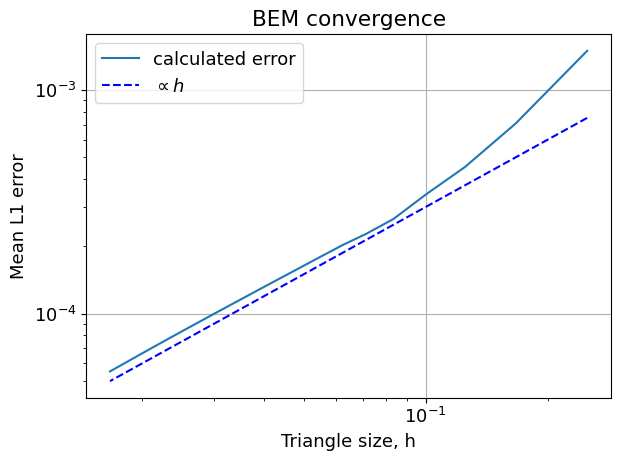

In [ ]:
mean_error_4pts_4blocks = np.load('/content/mean_error_4pts_4blocks.npy')
N0s = np.array([i for i in range(2, 31)])
plt.plot(1 / (2 * N0s), mean_error_4pts_4blocks, label='calculated error')
plt.plot(1 / (2 * N0s), 0.0015 / (N0s), 'b--', label=r'$\propto h$')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Triangle size, h')
plt.ylabel('Mean L1 error')
plt.title('BEM convergence')
plt.tight_layout()

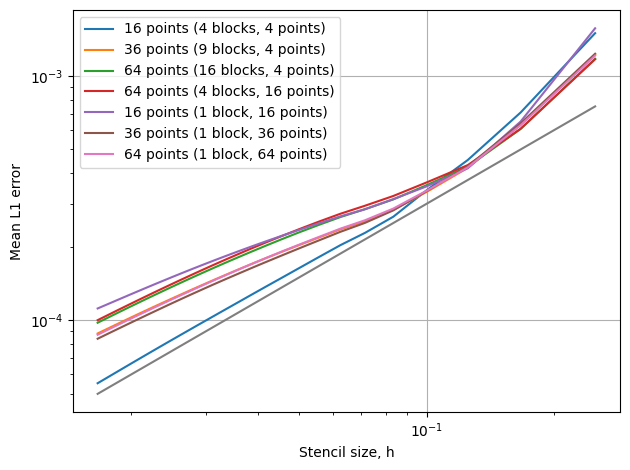

In [ ]:
N0s = np.array([i for i in range(2, 31)])
plt.plot(1 / (2 * N0s), mean_error_4pts_4blocks, label='16 points (4 blocks, 4 points)')
plt.plot(1 / (2 * N0s), mean_error_4pts_9blocks, label='36 points (9 blocks, 4 points)')
plt.plot(1 / (2 * N0s), mean_error_4pts_16blocks, label='64 points (16 blocks, 4 points)')
plt.plot(1 / (2 * N0s), mean_error_16pts_4blocks, label='64 points (4 blocks, 16 points)')
plt.plot(1 / (2 * N0s), mean_error_16pts_1block, label='16 points (1 block, 16 points)')
plt.plot(1 / (2 * N0s), mean_error_36pts_1block, label='36 points (1 block, 36 points)')
plt.plot(1 / (2 * N0s), mean_error_64pts_1block, label='64 points (1 block, 64 points)')
plt.plot(1 / (2 * N0s), 0.0015 / (N0s))
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Stencil size, h')
plt.ylabel('Mean L1 error')
plt.tight_layout()

## Sphere

In [ ]:
N, xt, yt, zt = stl2points('/content/Sphere.STL')
xt = (xt - np.max(xt) / 2 - np.min(xt) / 2)
yt = (yt - np.max(yt) / 2 - np.min(yt) / 2)
zt = (zt - np.max(zt) / 2 - np.min(zt) / 2)
xt = xt / np.max(xt)
yt = yt / np.max(yt)
zt = zt / np.max(zt)
r = 0.143 # mm
xt = xt * r
yt = yt * r
zt = zt * r

In [ ]:
print(f'x in range ({np.min(xt)}, {np.max(xt)})')
print(f'y in range ({np.min(yt)}, {np.max(yt)})')
print(f'z in range ({np.min(zt)}, {np.max(zt)})')

x in range (-0.143, 0.143)
y in range (-0.143, 0.143)
z in range (-0.143, 0.143)


In [ ]:
P_O2 = 140 # mmHg
D = 2e-3 # [mm^2 / sec] - diffusion coefficient
OCR = 20 # [mmHg / sec] - oxygen consumption rate

boundary_condition = P_O2
rhs_const = OCR / D

solver = BEMLaplace3D(N, xt, yt, zt)

bct = np.zeros(N)
bcv = np.zeros(N)

for i in range(N):
  bct[i] = 0
  bcv[i] = boundary_condition

bct, bcv = solver.bc_correction(bct, bcv, rhs_const)

phi, dphi = solver.linear_system(bct, bcv)

In [ ]:
np.save('phi_sphere.npy', phi)
np.save('dphi_sphere.npy', dphi)

In [ ]:
n = 128
x = np.linspace(-0.15, 0.15, n)
y = np.linspace(-0.15, 0.15, n)
z = np.linspace(-0.15, 0.15, 13)

X, Y, Z = np.meshgrid(x, y, z)
bem_sol = np.ones(X.shape) * P_O2

for i in tqdm(range(n)):
  for j in range(n):
    for k in range(13):
      if X[i, j, k] ** 2 +  Y[i, j, k] ** 2 + Z[i, j, k] ** 2 <= (r - 1e-3) ** 2:
        bem_sol[i, j, k] = solver.solution_poisson(X[i, j, k], Y[i, j, k], Z[i, j, k], rhs_const, phi, dphi)

100%|██████████| 128/128 [04:03<00:00,  1.90s/it]


In [ ]:
n = 256
x = np.linspace(-0.15, 0.15, n)
y = np.linspace(-0.15, 0.15, n)

X, Y = np.meshgrid(x, y)
bem_sol = np.ones(X.shape) * P_O2

for i in tqdm(range(n)):
  for j in range(n):
      if X[i, j] ** 2 +  Y[i, j] ** 2 <= (r - 2.5e-3) ** 2:
        bem_sol[i, j] = solver.solution_poisson(X[i, j], Y[i, j], 0, rhs_const, phi, dphi)

100%|██████████| 256/256 [02:19<00:00,  1.83it/s]


In [ ]:
np.save('BEM_spheroid_solution(256x256).npy', bem_sol)

In [ ]:
print(f'min(P_O2) = {np.min(bem_sol)}')

min(P_O2) = 105.9741332958623


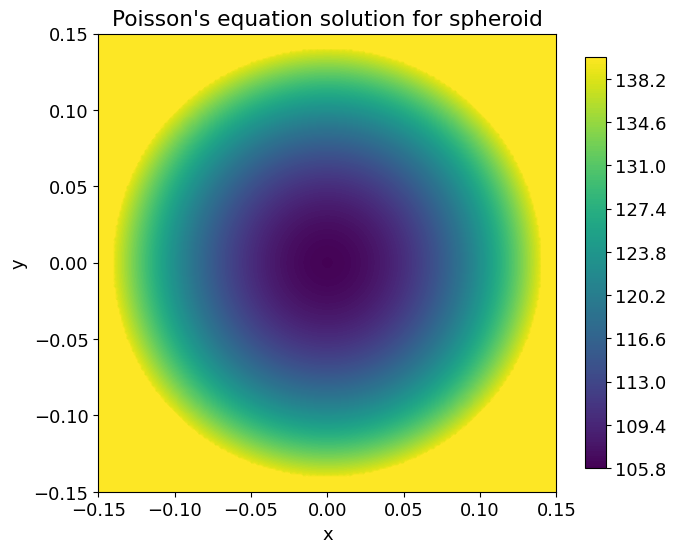

In [ ]:
matplotlib.rcParams.update({'font.size': 13})
plt.figure(figsize=(7, 6))
plt.contourf(X, Y, bem_sol, levels=200)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Poisson's equation solution for spheroid")
plt.gca().set_aspect('equal')
plt.colorbar(shrink=0.8)
plt.tight_layout()

In [ ]:
from google.colab import files
files.download('/content/BEM_spheroid_solution(128x128).npy')
files.download('/content/dphi_sphere.npy')
files.download('/content/phi_sphere.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Complex Geometry

In [ ]:
def min_area(x, y, bem_sol):
  min_val = np.min(bem_sol)
  x_min_area = x[(bem_sol > min_val) & (bem_sol < 1.05 * min_val)]
  y_min_area = y[(bem_sol > min_val) & (bem_sol < 1.05 * min_val)]
  return min_val, x_min_area, y_min_area



def artifact_correction(mesh, bem_sol, bc, smooth_order=8, number_of_layers=4, threshold=4.5):

  boundary_indices = mesh.boundaries(return_point_ids=True)
  bem_sol[boundary_indices] = bc

  x = mesh.vertices[:, 0]
  y = mesh.vertices[:, 1]
  z = mesh.vertices[:, 2]


  points_set = set()

  for i in range(boundary_indices.shape[0]):
    cp = mesh.connected_vertices(boundary_indices[i])
    for cp_ind in cp:
      if bem_sol[cp_ind] != 140:
        points_set.add(cp_ind)

  for _ in range(number_of_layers - 1):

    points = np.array(list(points_set))

    for i in range(points.shape[0]):
      cp = mesh.connected_vertices(points[i])
      for cp_ind in cp:
        if bem_sol[cp_ind] != 140:
          points_set.add(cp_ind)

  points = np.array(list(points_set))


  bad_points = []
  good_points = []

  median = np.median(bem_sol[points])
  z_score = 0.6745 * np.absolute(bem_sol[points] - median) / np.median(np.absolute(bem_sol[points] - median))
  for i in range(points.shape[0]):
      if z_score[i] > threshold:
        bad_points.append(points[i])
      else:
        good_points.append(points[i])

  bad_points = np.array(bad_points)
  good_points = np.array(good_points)


  for i in range(bad_points.shape[0]):
    cp_tobad = mesh.connected_vertices(bad_points[i])
    good_indices = []
    for ind in cp_tobad:
      if not (ind in bad_points):
        good_indices.append(ind)
    distances = (x[good_indices] - x[bad_points[i]]) ** 2 + (y[good_indices] - y[bad_points[i]]) ** 2 + (z[good_indices] - z[bad_points[i]]) ** 2
    weights = np.exp(-distances)
    weights = weights / np.sum(weights)
    bem_sol[bad_points[i]] = np.sum(bem_sol[good_indices] * weights)

  for _ in range(smooth_order):
    for i in range(points.shape[0]):
      cp = mesh.connected_vertices(points[i])
      distances = (x[cp] - x[points[i]]) ** 2 + (y[cp] - y[points[i]]) ** 2 + (z[cp] - z[points[i]]) ** 2
      weights = np.exp(-distances)
      weights = weights / np.sum(weights)
      bem_sol[points[i]] = np.sum(bem_sol[cp] * weights)

In [ ]:
def intersect_uniform_mesh(path, shift, scale, x_min, x_max, y_min, y_max, resolution, z_step):

    shift_x, shift_y, shift_z = shift
    msh = vd.Mesh(path)
    msh.shift(dx=shift_x, dy=shift_y, dz=shift_z)
    msh.scale(scale, origin=False)

    msh = msh.shift(dz=-z_step)

    plane = vd.Grid(pos=[x_min, x_max, y_min, y_max], res=(resolution, resolution)).wireframe(False)
    cutplane = plane.clone()
    cutplane.cut_with_mesh(msh)
    cutplane.triangulate()

    points = cutplane.vertices
    triangles = cutplane.cells
    x, y = points[:, 0], points[:, 1]

    return x, y, triangles, cutplane


def volume_mesh(path, side=0.02, gap=None):

  surf = vd.Mesh(path)
  volume_mesh = surf.tetralize(side=side, gap=gap)
  faces = volume_mesh.cells
  vertices = volume_mesh.vertices

  return vertices, faces


def capacity(phi, dphi, area):
  return np.sum(area * phi * dphi)

In [ ]:
N, xt, yt, zt = stl2points('/content/hole_1000um_edge_700um_modified.stl')

shift = (-(np.max(xt) + np.min(xt)) / 2, -(np.max(yt) + np.min(yt)) / 2, -(np.max(zt) + np.min(zt)) / 2)
shift_x, shift_y, shift_z = shift
xt = (xt + shift_x)
yt = (yt + shift_y)
zt = (zt + shift_z)

scale = (1 / np.max(zt), 1 / np.max(zt), 1 / np.max(zt))
scale_x, scale_y, scale_z = scale
xt = xt * scale_x
yt = yt * scale_y
zt = zt * scale_z

r = 1 # mm
xt = xt * r
yt = yt * r
zt = zt * r

In [ ]:
N

19513

In [ ]:
print(f'x in range ({np.min(xt)}, {np.max(xt)})')
print(f'y in range ({np.min(yt)}, {np.max(yt)})')
print(f'z in range ({np.min(zt)}, {np.max(zt)})')

x in range (-0.42430103549294285, 0.42430103549294285)
y in range (-0.42430103549294285, 0.42430103549294285)
z in range (-0.9999999999999999, 0.9999999999999999)


In [ ]:
P_O2 = 140 # mmHg
D = 2e-3 # [mm^2 / sec] - diffusion coefficient
OCR = 20 # [mmHg / sec] - oxygen consumption rate

boundary_condition = P_O2
rhs_const = OCR / D

solver = BEMLaplace3D(N, xt, yt, zt)

bct = np.zeros(N)
bcv = np.zeros(N)

for i in range(N):
  bct[i] = 0
  bcv[i] = boundary_condition

bct, bcv = solver.bc_correction(bct, bcv, rhs_const)

phi, dphi = solver.linear_system(bct, bcv)

In [ ]:
np.save('phi_complex.npy', phi)
np.save('dphi_complex.npy', dphi)

In [ ]:
x, y, triangles, cutplane = intersect_uniform_mesh('/content/hole_1000um_edge_700um_modified.stl', shift, scale, -0.5, 0.5, -0.5, 0.5, 256, 0.1)

In [ ]:
n = x.shape[0]
bem_sol = np.zeros(x.shape)

phi = np.load('/content/phi_complex.npy')
dphi = np.load('/content/dphi_complex.npy')

for i in tqdm(range(n)):
  bem_sol[i] = solver.solution_poisson(x[i], y[i], 0.1, rhs_const, phi, dphi)

100%|██████████| 10814/10814 [01:40<00:00, 108.04it/s]


In [ ]:
artifact_correction(cutplane, bem_sol, P_O2, smooth_order=8, number_of_layers=4, threshold=4.5)

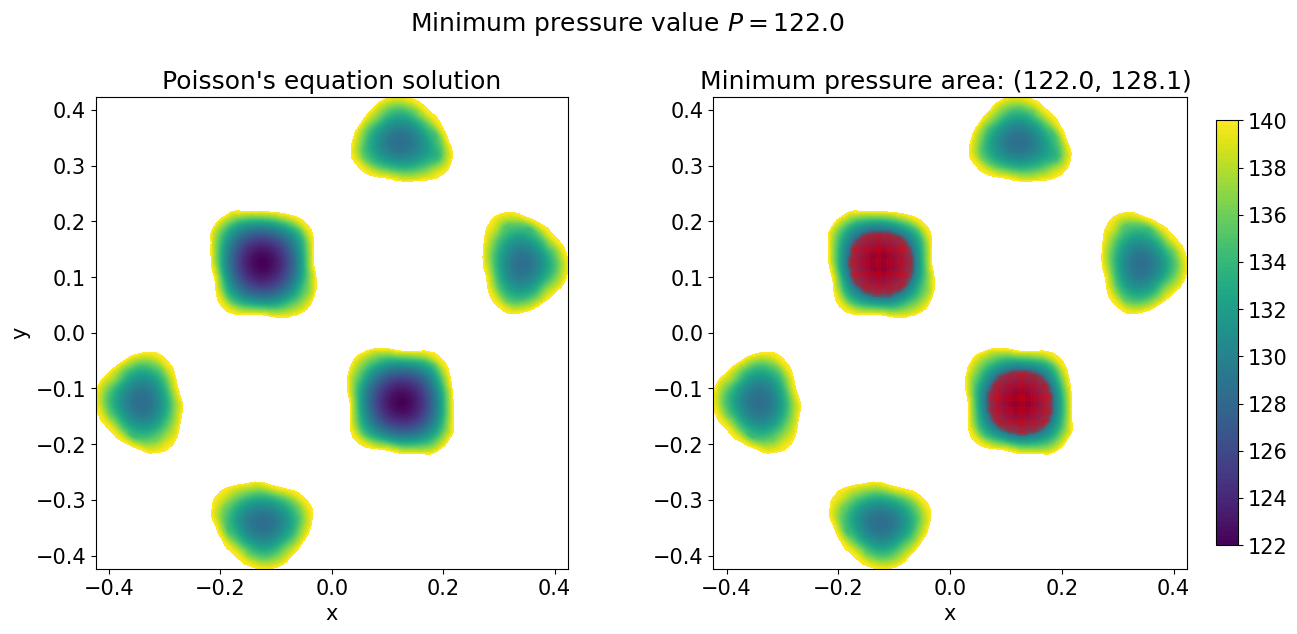

In [ ]:
matplotlib.rcParams.update({'font.size': 15})
min_val, min_x, min_y = min_area(x, y, bem_sol)

fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6.5))
ax1.set_aspect('equal')

ax1.tricontourf(x, y, triangles, bem_sol, levels=100)
tcf = ax2.tricontourf(x, y, triangles, bem_sol, levels=100)
ax2.scatter(min_x, min_y, s=10, alpha=0.1, c='red')

fig1.suptitle(f'Minimum pressure value $P = {min_val:.1f}$')
fig1.colorbar(tcf, shrink=0.9)
ax2.set_xlabel('x')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f"Poisson's equation solution")
ax2.set_title(f"Minimum pressure area: ({min_val:.1f}, {1.05 * min_val:.1f}) ")
plt.tight_layout()

Text(0.5, 1.0, "Solution of Poisson's equation for complex geometry")

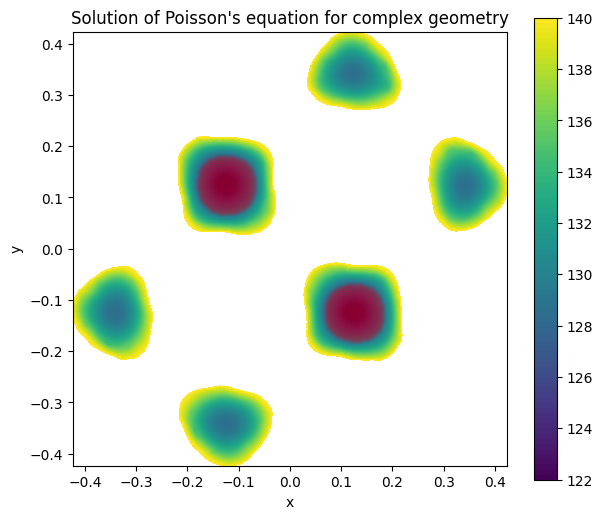

In [ ]:
fig1, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_aspect('equal')

tcf = ax1.tricontourf(x, y, triangles, bem_sol, levels=100)

fig1.colorbar(tcf)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title("Solution of Poisson's equation for complex geometry")

## Scaffolds

In [ ]:
N, xt, yt, zt = stl2points('/content/t_octa_cell_mod.stl')

shift = (-(np.max(xt) + np.min(xt)) / 2, -(np.max(yt) + np.min(yt)) / 2, -(np.max(zt) + np.min(zt)) / 2)
shift_x, shift_y, shift_z = shift
xt = (xt + shift_x)
yt = (yt + shift_y)
zt = (zt + shift_z)

scale = (1 / np.max(zt), 1 / np.max(zt), 1 / np.max(zt))
scale_x, scale_y, scale_z = scale
xt = xt * scale_x
yt = yt * scale_y
zt = zt * scale_z
r = 1 # mm
xt = xt * r
yt = yt * r
zt = zt * r

print(f'Number of elements: {N}')
print(f'x in range ({np.min(xt)}, {np.max(xt)})')
print(f'y in range ({np.min(yt)}, {np.max(yt)})')
print(f'z in range ({np.min(zt)}, {np.max(zt)})')

Number of elements: 26716
x in range (-0.9999963740083887, 0.9999963740083887)
y in range (-1.000000659271202, 1.000000659271202)
z in range (-1.0, 1.0)


In [ ]:
x21 = xt[:, 1] - xt[:, 0]
x31 = xt[:, 2] - xt[:, 0]
x23 = xt[:, 1] - xt[:, 2]
y21 = yt[:, 1] - yt[:, 0]
y31 = yt[:, 2] - yt[:, 0]
y23 = yt[:, 1] - yt[:, 2]
z21 = zt[:, 1] - zt[:, 0]
z31 = zt[:, 2] - zt[:, 0]
z23 = zt[:, 1] - zt[:, 2]


alpha = np.sqrt(x21 ** 2 + y21 ** 2 + z21 ** 2)
beta = np.sqrt(x23 ** 2 + y23 ** 2 + z23 ** 2)
gamma = np.sqrt(x31 ** 2 + y31 ** 2 + z31 ** 2)

print(f'length x: ({np.min(alpha)}, {np.max(alpha)})')
print(f'length y: ({np.min(beta)}, {np.max(beta)})')
print(f'length z: ({np.min(gamma)}, {np.max(gamma)})')

length x: (0.014215223536247257, 0.08486379028206581)
length y: (0.019243556353850298, 0.08721080295271515)
length z: (0.014215223536247257, 0.08623845690068772)


In [ ]:
P_O2 = 140 # mmHg
D = 2e-3 # [mm^2 / sec] - diffusion coefficient
OCR = 20 # [mmHg / sec] - oxygen consumption rate

boundary_condition = P_O2
rhs_const = OCR / D

solver = BEMLaplace3D(N, xt, yt, zt)

bct = np.zeros(N)
bcv = np.zeros(N)

for i in range(N):
  bct[i] = 0
  bcv[i] = boundary_condition

bct, bcv = solver.bc_correction(bct, bcv, rhs_const)

phi, dphi = solver.linear_system(bct, bcv)

In [ ]:
np.save('phi_scaffold.npy', phi)
np.save('dphi_scaffold.npy', dphi)

In [ ]:
z = np.linspace(-1, 1, 51)[1:-1]
x_list = []
y_list = []
triangles_list = []
bem_sol_list = []

phi = np.load('/content/phi_scaffold.npy')
dphi = np.load('/content/dphi_scaffold.npy')

for i in range(z.shape[0]):

  x, y, triangles, mesh = intersect_uniform_mesh('/content/t_octa_cell_mod.stl', shift, scale, -1, 1, -1, 1, 256, z[i])
  triangles = np.array(triangles)
  x_list.append(x)
  y_list.append(y)
  triangles_list.append(triangles)

  n = x.shape[0]
  bem_sol = np.zeros(x.shape)

  for j in tqdm(range(n)):
    bem_sol[j] = solver.solution_poisson(x[j], y[j], z[i], rhs_const, phi, dphi)

  artifact_correction(mesh, bem_sol, P_O2, smooth_order=8, number_of_layers=4, threshold=4.5)

  bem_sol_list.append(bem_sol)

100%|██████████| 13586/13586 [01:46<00:00, 128.17it/s]


In [ ]:
np.save('x_list.npy', np.array(x_list, dtype=object), allow_pickle=True)
np.save('y_list.npy', np.array(y_list, dtype=object), allow_pickle=True)
np.save('triangles_list.npy', np.array(triangles_list, dtype=object), allow_pickle=True)
np.save('bem_sol_list.npy', np.array(bem_sol_list, dtype=object), allow_pickle=True)

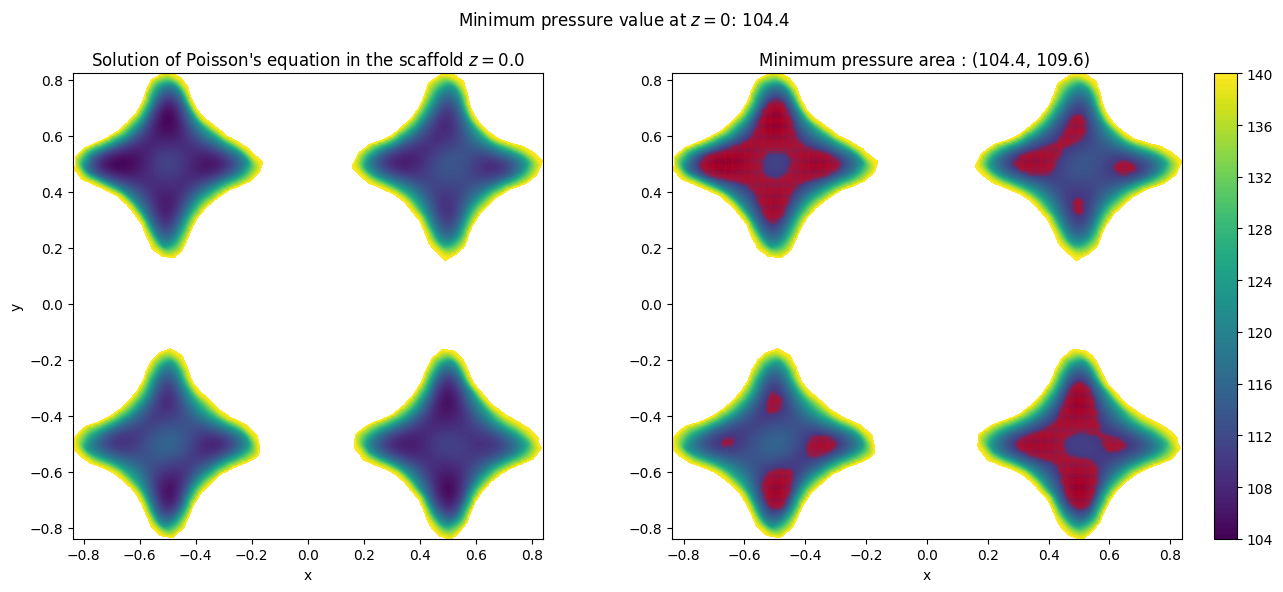

In [ ]:
min_val, min_x, min_y = min_area(x_list[24], y_list[24], bem_sol_list[24])

fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.set_aspect('equal')

ax1.tricontourf(x_list[24], y_list[24], triangles_list[24], bem_sol_list[24], levels=100)
tcf = ax2.tricontourf(x_list[24], y_list[24], triangles_list[24], bem_sol_list[24], levels=100)
ax2.scatter(min_x, min_y, s=10, alpha=0.1, c='red')

fig1.suptitle(f'Minimum pressure value at $z = 0$: {min_val:.1f}')
fig1.colorbar(tcf)
ax2.set_xlabel('x')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f"Solution of Poisson's equation in the scaffold $z = {z[24]}$")
ax2.set_title(f"Minimum pressure area : ({min_val:.1f}, {1.05 * min_val:.1f}) ")
plt.tight_layout()

In [ ]:
minimal = np.zeros(z.shape[0])
for i in range(z.shape[0]):
  minimal[i], min_x, min_y = min_area(x_list[i], y_list[i], bem_sol_list[i])

In [ ]:
minimal

array([ 120.31749416,  -82.72418253,  114.62549459,  115.38071003,
        113.66511734,  111.27085838,  106.07492283,  103.22008177,
        103.0674337 ,  104.98717308,  106.83746045,  103.85464698,
        103.91890631,   38.5136884 ,  106.48693624,  105.32073386,
        106.0228506 ,  109.1426772 ,  114.75259178,  115.89568233,
        115.84210767,  113.58636345,   89.53050099,  105.9417366 ,
        104.38880807,  107.04049623,  110.22085394,  115.50460158,
        116.80025638,  117.72024682,  116.21811117,  110.47693827,
        107.59830849,  106.97325629,  108.00300784,  108.94113463,
        105.05221702,  105.21857331,  -16.28575052,  106.61117951,
        105.43536489,  106.01611241,  108.99132621,  114.08040498,
        116.59280758,  117.45717813,  118.15099139, -171.34374874,
        121.95384016])

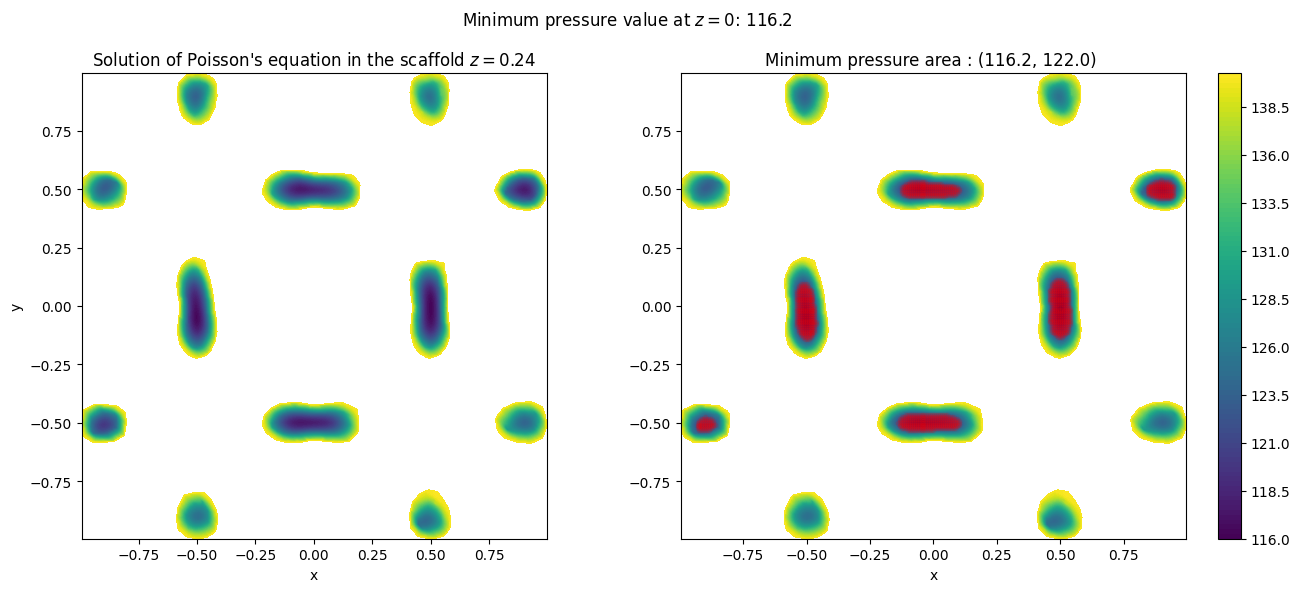

In [ ]:
ind = 30

min_val, min_x, min_y = min_area(x_list[ind], y_list[ind], bem_sol_list[ind])

fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.set_aspect('equal')

ax1.tricontourf(x_list[ind], y_list[ind], triangles_list[ind], bem_sol_list[ind], levels=100)
tcf = ax2.tricontourf(x_list[ind], y_list[ind], triangles_list[ind], bem_sol_list[ind], levels=100)
ax2.scatter(min_x, min_y, s=10, alpha=0.1, c='red')

fig1.suptitle(f'Minimum pressure value at $z = 0$: {min_val:.1f}')
fig1.colorbar(tcf)
ax2.set_xlabel('x')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f"Solution of Poisson's equation in the scaffold $z = {z[ind]}$")
ax2.set_title(f"Minimum pressure area : ({min_val:.1f}, {1.05 * min_val:.1f}) ")
plt.tight_layout()

In [ ]:
vertices, cells = volume_mesh('/content/t_octa_cell_mod.stl', side=0.005)
vertices.shape

(100818, 3)

In [ ]:
msh

(array([[ 133.13913 , -182.56491 , -233.70612 ],
        [-129.239   ,  -73.80515 , -233.9741  ],
        [-129.2438  ,   56.524628, -234.84431 ],
        ...,
        [-247.65913 ,  114.27806 ,   51.88927 ],
        [-244.69156 ,  133.46953 ,   44.12757 ],
        [-243.10164 ,  143.89917 ,   50.740337]], dtype=float32),
 [[3282, 3283, 2, 3284],
  [59, 11962, 11934, 12085],
  [8376, 8486, 8351, 8518],
  [8662, 8573, 8587, 8665],
  [2991, 2993, 2, 3058],
  [7747, 7882, 9, 9816],
  [5280, 5115, 4911, 5324],
  [5577, 5609, 86, 5813],
  [3626, 3942, 3701, 3970],
  [12, 3730, 3634, 3765],
  [3584, 3663, 57, 3886],
  [3049, 3062, 3025, 3063],
  [78, 4381, 88, 4523],
  [3244, 3263, 3243, 3264],
  [8759, 8737, 8666, 8871],
  [11609, 11791, 94, 11843],
  [3919, 3765, 12, 4064],
  [4232, 4470, 35, 4638],
  [3740, 4040, 3899, 4197],
  [3938, 4306, 12, 4336],
  [8506, 8782, 8711, 8795],
  [9223, 9235, 9141, 9248],
  [3512, 3551, 12, 3714],
  [8047, 8179, 58, 8265],
  [748, 1319, 511, 1468],
  [10

## Fast Multipole Method

In [ ]:
class Cell():
    """The class for a cell.

    Arguments:
      n_crit: maximum number of particles in a leaf cell

    Attributes:
        nleaf (int): number of particles in the cell.
        leaf (array of int): array of leaves indices.
        nchild (int): 8-bit binary number, used to keep track of the empty child cells
        child (array of int): array of children indices.
        parent (int): index of parent cell.
        x, y, z (float): coordinates of the cell's center.
        r (float): radius of the cell (half of the length for cubic cell).
        multipole (array of float): array of multipoles' cell.

    """
    def __init__(self, n_crit):
        self.nleaf = 0        # number of particles
        self.leaf = np.zeros(n_crit, dtype=np.int32)     # array of leaf index
        self.nchild = 0       # binary counter to keep track of empty cells
        self.child = np.zeros(8, dtype=np.int32)         # array of child index
        self.parent = 0       # index of parent cell
        self.x = self.y = self.z = 0.                    # center of the cell
        self.r = 0.           # radius of the cell
        self.multipole = np.zeros(10, dtype=np.float64)  # multipole array



def add_child(octant, p, cells, n_crit):
    """Add a cell to the end of cells list as a child of p,
       initialize the center and radius of the child cell c,
       and establish mutual reference between child c and parent p.

    Arguments:
        octant: reference to the corresponding octant in 3D structure.
        p: is the index (in the cells list) of the corresponding parent.
        cells: the list of cells.
        n_crit: maximum number of particles in a leaf cell.

    """
    # create a new cell instance and append it to cells list
    cells.append(Cell(n_crit))
    # the last element of the cells list is the new child c
    c = len(cells) - 1
    # geometric relationship between parent and child
    cells[c].r = cells[p].r / 2
    cells[c].x = cells[p].x + cells[c].r * ((octant & 1) * 2 - 1)
    cells[c].y = cells[p].y + cells[c].r * ((octant & 2) - 1    )
    cells[c].z = cells[p].z + cells[c].r * ((octant & 4) / 2 - 1)
    # establish mutual reference in the cells list
    cells[c].parent = p
    cells[p].child[octant] = c
    cells[p].nchild = (cells[p].nchild | (1 << octant))
    print('+++cell {} is created as a child of cell {}'.format(c, p))


def split_cell(particles, p, cells, n_crit):
    """Loop in parent p's leaves and reallocate the particles to subcells.
    If a subcell has not been created in that octant, it creates one using
    add_child. If the subcell nleaf exceeds n_crit, split the
    subcell c recursively.

    Arguments:
        particles: the list of particles.
        p: is the index (in the cells list) of the corresponding parent.
        cells: the list of cells.
        n_crit: maximum number of particles in a leaf cell.

    """
    print('======start the split of cell {}======'.format(p))
    # loop over the particles in the parent cell that you want to split
    for l in cells[p].leaf:
        octant = (particles[l][0] > cells[p].x) + ((particles[l][1] > cells[p].y) << 1) \
               + ((particles[l][2] > cells[p].z) << 2)   # finding the particle's octant
        # if there is not a child cell in the particle's octant, then create one
        if not cells[p].nchild & (1 << octant):
            add_child(octant, p, cells, n_crit)
        # reallocate the particle in the child cell
        c = cells[p].child[octant]
        cells[c].leaf[cells[c].nleaf] = l
        cells[c].nleaf += 1
        print('>>>particle {} is reallocated in cell {}'.format(l, c))
        # check if the child reach n_crit
        if cells[c].nleaf >= n_crit:
            split_cell(particles, c, cells, n_crit)
    print('======end split cell {}======'.format(p))


def build_tree(particles, root, n_crit):
    """Construct a hierarchical octree to store the particles and
       return the tree (list) of cells.

    Arguments:
        particles: the list of particles.
        root: the root cell.
        n_crit: maximum number of leaves in a single cell.

    Returns:
        cells: the list of cells

    """
    # set root cell
    cells = [root]       # initialize the cells list

    # build tree
    n = len(particles)
    for i in range(n):
        # traverse from the root down to a leaf cell
        curr = 0
        while cells[curr].nleaf >= n_crit:
            cells[curr].nleaf += 1
            octant = (particles[i][0] > cells[curr].x) + ((particles[i][1] > cells[curr].y) << 1) \
                   + ((particles[i][2] > cells[curr].z) << 2)
            # if there is no child cell in the particles octant, then create one
            if not cells[curr].nchild & (1 << octant):
                add_child(octant, curr, cells, n_crit)
            curr = cells[curr].child[octant]
        # allocate the particle in the leaf cell
        cells[curr].leaf[cells[curr].nleaf] = i
        cells[curr].nleaf += 1
        print('particle {} is stored in cell {}'.format(i, curr))
        # check whether to split or not
        if cells[curr].nleaf >= n_crit:
            split_cell(particles, curr, cells, n_crit)

    return cells


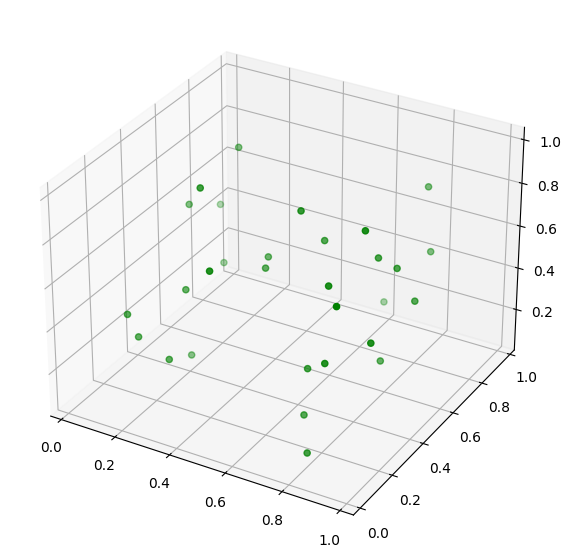

In [ ]:
nodes = np.random.random(size=(30, 3))
x, y, z = nodes[:, 0], nodes[:, 1], nodes[:, 2]
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(x, y, z, color = "green")

root = Cell(10)
root.x, root.y, root.z = 0.5, 0.5, 0.5
root.r = 0.5

In [ ]:
cells = build_tree(nodes, root, 10)

particle 0 is stored in cell 0
particle 1 is stored in cell 0
particle 2 is stored in cell 0
particle 3 is stored in cell 0
particle 4 is stored in cell 0
particle 5 is stored in cell 0
particle 6 is stored in cell 0
particle 7 is stored in cell 0
particle 8 is stored in cell 0
particle 9 is stored in cell 0
======start the split of cell 0======
+++cell 1 is created as a child of cell 0
>>>particle 0 is reallocated in cell 1
+++cell 2 is created as a child of cell 0
>>>particle 1 is reallocated in cell 2
>>>particle 2 is reallocated in cell 1
+++cell 3 is created as a child of cell 0
>>>particle 3 is reallocated in cell 3
+++cell 4 is created as a child of cell 0
>>>particle 4 is reallocated in cell 4
+++cell 5 is created as a child of cell 0
>>>particle 5 is reallocated in cell 5
>>>particle 6 is reallocated in cell 1
>>>particle 7 is reallocated in cell 1
>>>particle 8 is reallocated in cell 3
+++cell 6 is created as a child of cell 0
>>>particle 9 is reallocated in cell 6
======end 